<h1 style="text-align: center;">Binary Classification of Rice Varieties</h1>
<h3 style="text-align: center;">By Trevor Portillo</h3>
<h4 style="text-align: center;">ITSC - 3156</h4>

### Introduction:
This project focuses on applying machine learning algorithms to classify rice varieties from grayscale images. The dataset contains images of two rice varieties: Karacadag and Arborio. The goal is to build a machine learning pipeline to preprocess the images, extract features, and classify them into one of the two categories. Logistic Regression and K-Nearest Neighbors (KNN) are used as the two algorithms for classification.

Machine learning is widely used in agriculture to automate quality control and variety identification. The motivation for this project is to explore how well traditional machine learning algorithms perform on this task using a publicly available dataset. The dataset consists of 75,000 grayscale images, resized to 128x128 pixels, which ensures sufficient complexity and features.

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.model_selection import cross_val_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

#### About the Data:
- The dataset contains images of five rice varieties: Karacadag, Arborio, Basmati, Ipsala, and Jasmine
- For our purposes we decided to look at two of them, Karacadag and Arborio 
- Each image is a grayscale representation of a rice grain, with dimensions standardized to 128x128 pixels 
- There are 15,000 samples in each class (30,000 total) ensuring that the dataset is large enough to challenge the models

In [2]:
data_dir = "C:\\Users\\newtr\\OneDrive\\Desktop\\FinalProject"
categories = ["Karacadag", "Arborio"]

# Initialize data and labels
data = []
labels = []

# Loop through each class folder
for category in categories:
    folder_path = os.path.join(data_dir, category)
    class_label = categories.index(category)  # Assign label 0 or 1 based on folder order
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            data.append(img)
            labels.append(class_label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)


#### Data Preprocessing: 
- As seen above, images were resized to 128x128 pixels to ensure uniformity
- Pixel values were normalized to a range of 0 to 1 to improve the performance of machine learning algorithms 
- Flattening was applied to convert the images into 1D vectors, as Logistic Regression and KNN require numerical features. 

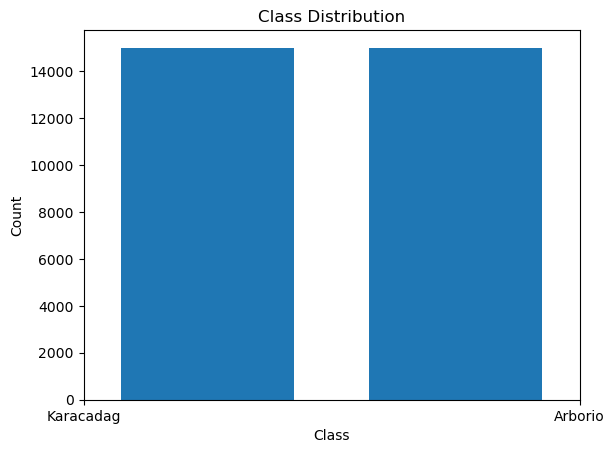

In [3]:
plt.hist(labels, bins=len(categories), align='mid', rwidth=0.7)
plt.xticks(ticks=range(len(categories)), labels=categories)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [4]:
# Normalize pixel values
data = data / 255.0

data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True
)

datagen.fit(data)

augmented_data = []
augmented_labels = []

for batch_data, batch_labels in datagen.flow(data, labels, batch_size=32):
    augmented_data.append(batch_data)
    augmented_labels.append(batch_labels)
    
    if len(augmented_data) * 32 >= len(data):  
        break

augmented_data = np.vstack(augmented_data)
augmented_labels = np.hstack(augmented_labels)

### Pixel Intensity Distribution
This plot shows the distribution of pixel intensity values across all images in the dataset. Pixel intensities range from 0 (black) to 255 (white) before normalization. Understanding this distribution helps us assess the diversity of the dataset and ensure that preprocessing steps like normalization are applied correctly.


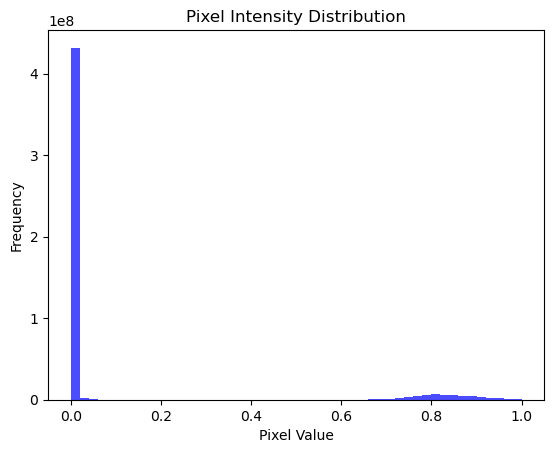

In [6]:
# Visualize pixel intensity distribution
plt.hist(data.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

- As seen in the chart above an overwhelming amount of the pixels in the images are 0 (black).  This is because around each grain of rice is simply a black background. Most of the data that comes from the rice itself comes from the 0.6 to 1.0 (white) range.

#### Data Augmentation Visualization
- Below are examples of the original and augmented images.
- Augmentation techniques like rotation and flipping help increase dataset variability and improve model generalization.


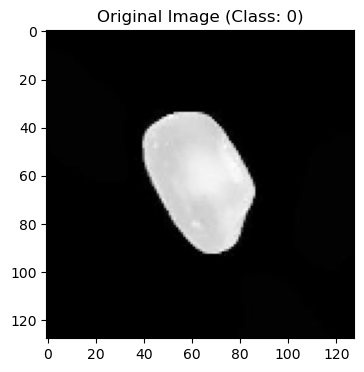

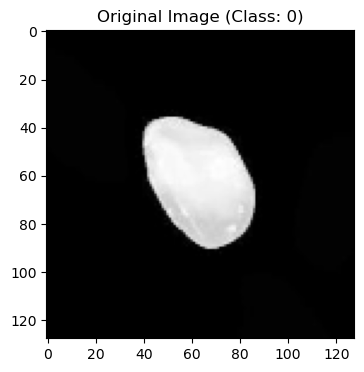

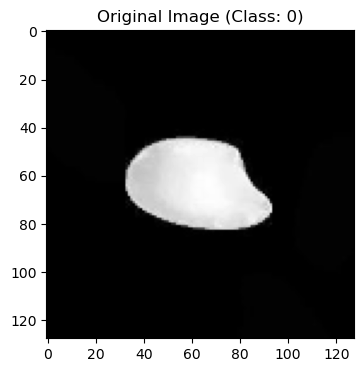

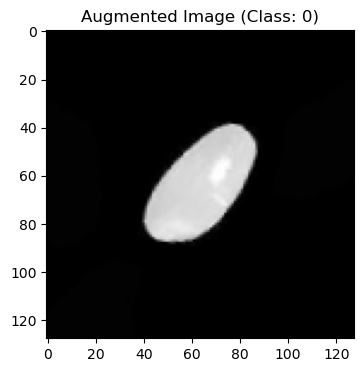

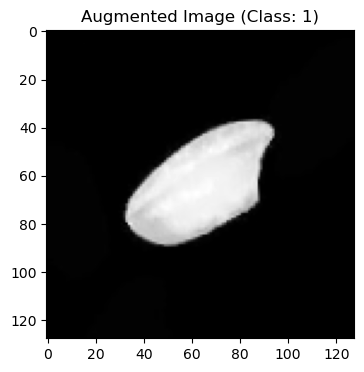

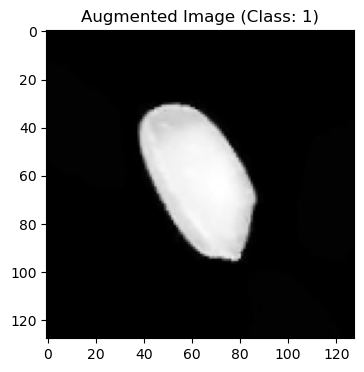

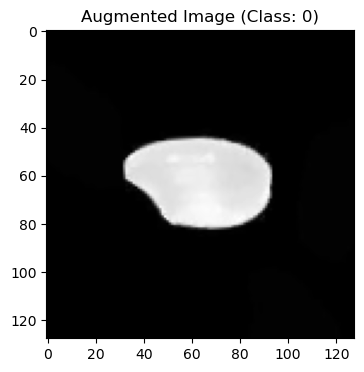

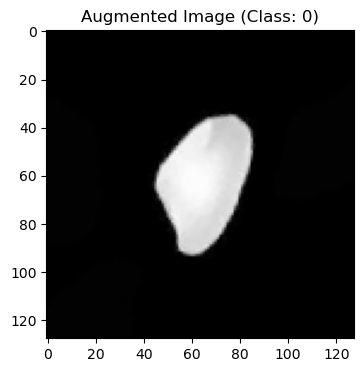

In [7]:
# Display original images
for i in range(3):
    plt.figure(figsize=(4, 4))
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.title(f"Original Image (Class: {labels[i]})")
    plt.show()

# Display augmented images
for batch_data, batch_labels in datagen.flow(data, labels, batch_size=5):
    for i in range(5):
        plt.figure(figsize=(4, 4))
        plt.imshow(batch_data[i].squeeze(), cmap='gray')
        plt.title(f"Augmented Image (Class: {batch_labels[i]})")
        plt.show()
    break


#### Data Flattening
- Below the image data is flattened into 1D vectors so they can be used by logistic regression and KNN

In [8]:
# Flatten augmented images into 1D vectors
augmented_data_flattened = augmented_data.reshape(augmented_data.shape[0], -1)

#### Data Augmentation
- Data augmentation increases dataset variability by applying transformations like rotation and flipping.
- This technique helps prevent overfitting and improves model robustness.


In [9]:
# Split the Data into training and test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(augmented_data_flattened, augmented_labels, test_size=0.2, random_state=42)

#### Logistic Regression Reasoning:
- Logistic Regression was chosen because it is a simple and interpretable algorithm. It works well for linearly separable data and provides probabilistic outputs, making it useful for binary classification tasks.

In [10]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2976
           1       0.97      0.96      0.96      3024

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



#### K-NN Reasoning:
- KNN was selected because it is a distance-based algorithm. It is straightforward to implement and can capture non-linear relationships if the data is properly normalized. The hyperparameter k determines the number of neighbors used for voting, and in this project, k is determined by the below.

#### Hyperparameter Tuning for KNN:
- The performance of the KNN algorithm depends on the value of `k` (the number of neighbors). To find a better value, we use `GridSearchCV`, which performs cross-validation over a grid of `k` values. The best `k` is chosen based on the cross-validation accuracy.


In [11]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Perform GridSearchCV to find the best k
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Display the results
print("Best k:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best k: {'n_neighbors': 3}
Best cross-validation accuracy: 0.9679583333333334


- After tuning the k value it is then used in order to train the model

In [12]:
best_k = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn))


KNN Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2976
           1       0.99      0.95      0.97      3024

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



### Dynamic Metric Calculation

This section calculates and compares the performance metrics for both Logistic Regression and KNN models. The metrics include:
- **Accuracy**: The overall correctness of the model's predictions.
- **Precision (0 and 1)**: The proportion of correctly predicted samples for each class out of all samples predicted for that class.
- **Recall (0 and 1)**: The proportion of correctly predicted samples for each class out of all actual samples in that class.

The calculations are performed dynamically using the actual test labels (`y_test`) and predictions from both models (`y_pred_logistic` and `y_pred_knn`). This ensures that the results reflect the true performance of the models on unseen data.

The metrics are presented in a table for a clear comparison between the two models, highlighting their strengths and weaknesses.


In [13]:
# Calculate metrics for both models
metrics_dynamic = {
    "Metric": ["Accuracy", "Precision (0)", "Precision (1)", "Recall (0)", "Recall (1)"],
    "Logistic Regression": [
        accuracy_score(y_test, y_pred_logistic) * 100,
        precision_score(y_test, y_pred_logistic, pos_label=0) * 100,
        precision_score(y_test, y_pred_logistic, pos_label=1) * 100,
        recall_score(y_test, y_pred_logistic, pos_label=0) * 100,
        recall_score(y_test, y_pred_logistic, pos_label=1) * 100,
    ],
    "KNN": [
        accuracy_score(y_test, y_pred_knn) * 100,
        precision_score(y_test, y_pred_knn, pos_label=0) * 100,
        precision_score(y_test, y_pred_knn, pos_label=1) * 100,
        recall_score(y_test, y_pred_knn, pos_label=0) * 100,
        recall_score(y_test, y_pred_knn, pos_label=1) * 100,
    ],
}

# Create a DataFrame for comparison
metrics_df_dynamic = pd.DataFrame(metrics_dynamic)

# Display the dynamically generated DataFrame
print(metrics_df_dynamic)

          Metric  Logistic Regression        KNN
0       Accuracy            96.316667  96.700000
1  Precision (0)            95.809777  94.922380
2  Precision (1)            96.825927  98.590096
3     Recall (0)            96.807796  98.622312
4     Recall (1)            95.833333  94.808201


In [14]:
# Cross-validation for Logistic Regression
logistic_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
print("Cross-validation scores for Logistic Regression:", logistic_scores)
print("Mean accuracy for Logistic Regression:", np.mean(logistic_scores))

# Cross-validation for KNN
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=5)
print("Cross-validation scores for KNN:", knn_scores)
print("Mean accuracy for KNN:", np.mean(knn_scores))


Cross-validation scores for Logistic Regression: [0.96708333 0.965625   0.9675     0.963125   0.96854167]
Mean accuracy for Logistic Regression: 0.966375
Cross-validation scores for KNN: [0.96958333 0.968125   0.96541667 0.96708333 0.96958333]
Mean accuracy for KNN: 0.9679583333333334


### Cross-Validation Results
- Cross-validation ensures the models generalize well to unseen data by training and testing on different splits of the dataset.
- The mean accuracy for Logistic Regression and KNN across 5 folds was:
- Logistic Regression: 96.64%
- KNN: 96.80%


### Example data results

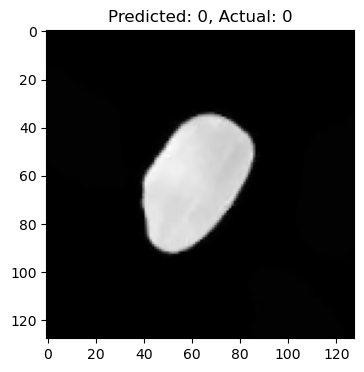

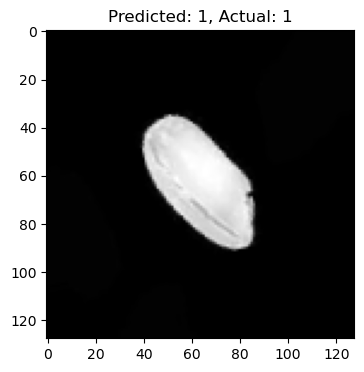

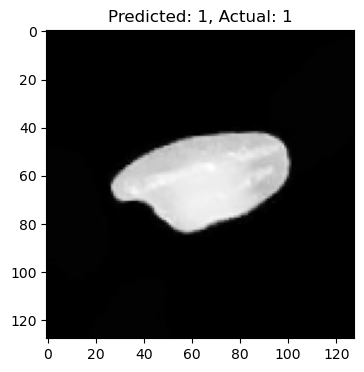

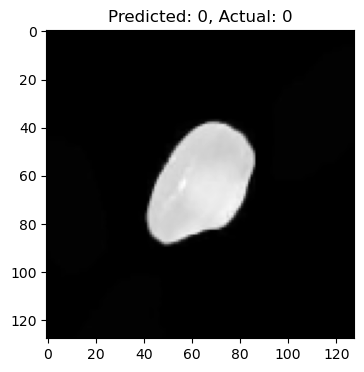

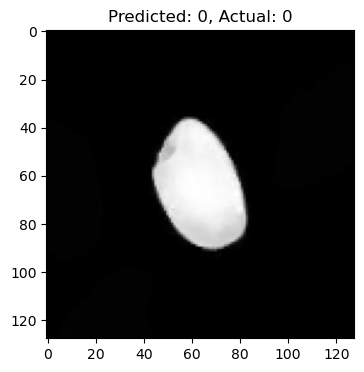

In [15]:
for i in range(5):
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title(f"Predicted: {y_pred_knn[i]}, Actual: {y_test[i]}")
    plt.show()

### Confusion matrix and Misclassification examples for k-NN

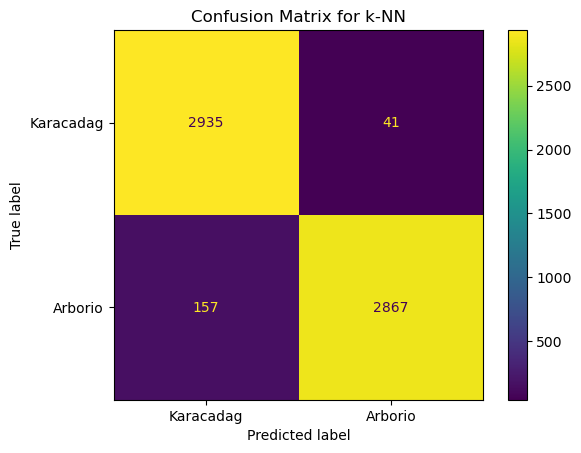

In [16]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()
plt.title("Confusion Matrix for k-NN")
plt.show()


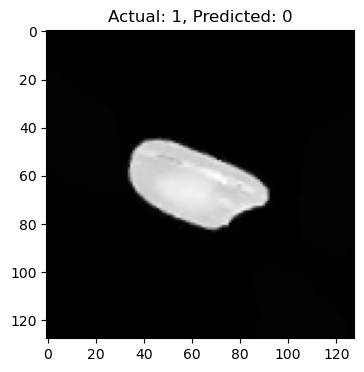

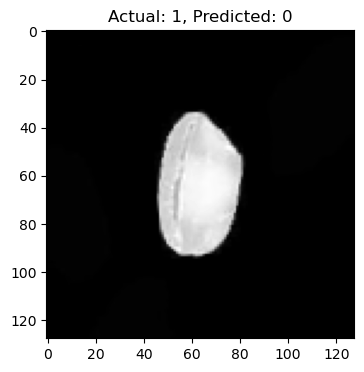

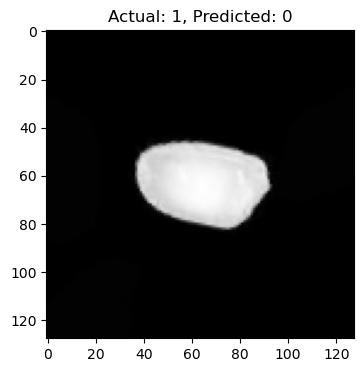

In [17]:
# Display 3 misclassified samples
misclassified_count = 0 
max_misclassified = 3    # Maximum number images to display

for i in range(len(y_test)):
    if y_test[i] != y_pred_knn[i]:  # Check if the prediction is incorrect
        plt.figure(figsize=(4, 4))
        plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
        plt.title(f"Actual: {y_test[i]}, Predicted: {y_pred_knn[i]}")
        plt.show()
        misclassified_count += 1  # Increment the counter
        
        if misclassified_count == max_misclassified:
            break


### Confusion matrix and Misclassification examples for Logistic Regression

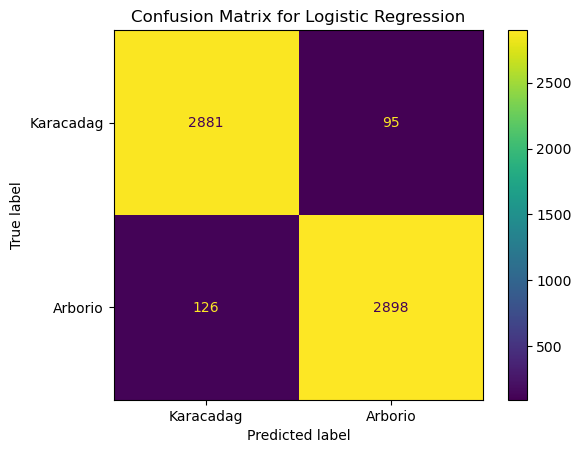

In [18]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=categories)
disp_logistic.plot(cmap='viridis')
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

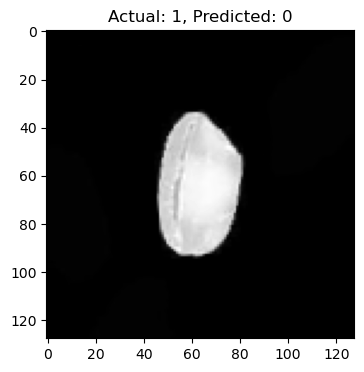

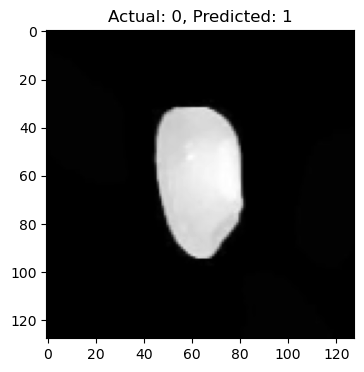

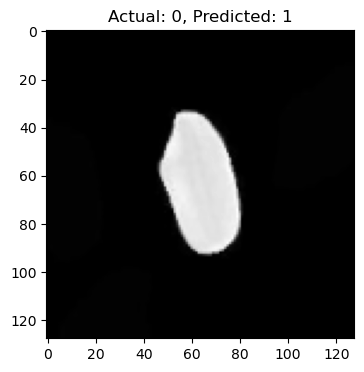

In [21]:
# Display 3 misclassified samples
misclassified_count = 0 
max_misclassified = 3    # Maximum number images to display

for i in range(len(y_test)):
    if y_test[i] != y_pred_logistic[i]:  # Check if the prediction is incorrect
        plt.figure(figsize=(4, 4))
        plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
        plt.title(f"Actual: {y_test[i]}, Predicted: {y_pred_logistic[i]}")
        plt.show()
        misclassified_count += 1  # Increment the counter
        
        if misclassified_count == max_misclassified:
            break


### Reasoning for Misclassifictions
- Most misclassifications happen as misclassified samples often exhibit overlapping pixel patterns between the two rice varieties

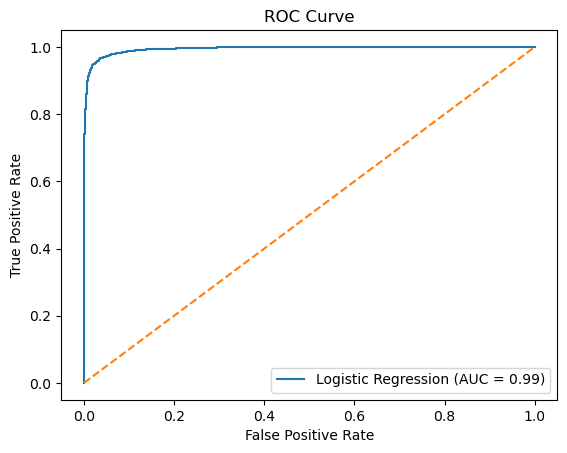

In [20]:
y_probs_logistic = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Conclusion
- This project successfully classified rice varieties using Logistic Regression and KNN.
- KNN slightly outperformed Logistic Regression, showing its ability to capture non-linear relationships.
- Data augmentation and preprocessing significantly improved the robustness of both models.
- These results demonstrate the potential for automating quality control processes in agriculture. Another possible application of this is for seed sorting and identification.
- Future work could involve testing more advanced models like CNNs or applying the pipeline to multi-class classification with all five rice varieties.


### References
- "Rice Images Dataset" Mohammad Soroush. https://www.kaggle.com/datasets/mbsoroush/rice-images-dataset
- scikit-learn: https://scikit-learn.org/stable/
- Matplotlib: https://matplotlib.org/
- TensorFlow: https://www.tensorflow.org/
